In [1]:
import torch
import pandas as pd
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration

test_df = pd.read_csv("dataset/test_processed.csv")

In [2]:
tokenizer_t5 = T5Tokenizer.from_pretrained("google-t5/t5-large")

device = torch.device("cuda") # GPU usage
model_t5 = T5ForConditionalGeneration.from_pretrained("google-t5/t5-large")
model_t5.to(device)

tokenizer_t5.model_max_length, model_t5

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


(1000000000000000019884624838656,
 T5ForConditionalGeneration(
   (shared): Embedding(32128, 1024)
   (encoder): T5Stack(
     (embed_tokens): Embedding(32128, 1024)
     (block): ModuleList(
       (0): T5Block(
         (layer): ModuleList(
           (0): T5LayerSelfAttention(
             (SelfAttention): T5Attention(
               (q): Linear(in_features=1024, out_features=1024, bias=False)
               (k): Linear(in_features=1024, out_features=1024, bias=False)
               (v): Linear(in_features=1024, out_features=1024, bias=False)
               (o): Linear(in_features=1024, out_features=1024, bias=False)
               (relative_attention_bias): Embedding(32, 16)
             )
             (layer_norm): T5LayerNorm()
             (dropout): Dropout(p=0.1, inplace=False)
           )
           (1): T5LayerFF(
             (DenseReluDense): T5DenseActDense(
               (wi): Linear(in_features=1024, out_features=4096, bias=False)
               (wo): Linear(in_featur

In [3]:
tokenizer_t5.model_max_length = 4096 

In [4]:
def GoBackReadingWindow(model, tokenizer, text):
    torch.cuda.empty_cache()
    if len(text.split()) < tokenizer.model_max_length:
        inputs = tokenizer("summarize: " + text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=0, max_new_tokens=tokenizer.model_max_length)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    OVERLAP = int(tokenizer.model_max_length * 0.2)
    words = text.split()
    chunks = []
    start = 0

    while start < len(words):
        end = min(start + tokenizer.model_max_length, len(words))
        chunks.append(' '.join(words[start:end]))
        start += tokenizer.model_max_length - OVERLAP

    print(len(chunks))
    
    summarized_chunks = []
    for chunk in chunks:
        inputs = tokenizer("summarize: " + chunk,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=0, max_new_tokens=tokenizer.model_max_length)
        summarized_chunks.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        torch.cuda.empty_cache()
    
    summarized_text = ' '.join(summarized_chunks)
    
    if len(summarized_text.split()) > tokenizer.model_max_length:
        return GoBackReadingWindow(model, tokenizer, summarized_text)
    else:
        inputs = tokenizer("summarize: " + summarized_text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=0, max_new_tokens=tokenizer.model_max_length)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [5]:
def ReadingAfterwardsWindow(model, tokenizer, text):
    torch.cuda.empty_cache()
    if len(text.split()) < tokenizer.model_max_length:
        inputs = tokenizer("summarize: " + text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=0, max_new_tokens=tokenizer.model_max_length)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    OVERLAP = int(tokenizer.model_max_length * 0.2)
    words = text.split()
    chunks = []
    start = 0

    isfirts = True
    while start < len(words):
        end = min(start + tokenizer.model_max_length, len(words))
        if isfirts:
            chunks.append(' '.join(words[start:end]))
            isfirts = False
        else:
            chunks.append(' '.join(words[start + OVERLAP:end]) + " " + ' '.join(words[start:start + OVERLAP]))
        start += tokenizer.model_max_length - OVERLAP

    print(len(chunks))
    
    summarized_chunks = []
    for chunk in chunks:
        inputs = tokenizer("summarize: " + chunk,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=0, max_new_tokens=tokenizer.model_max_length)
        summarized_chunks.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        torch.cuda.empty_cache()
    
    summarized_text = ' '.join(summarized_chunks)
    
    if len(summarized_text.split()) > tokenizer.model_max_length:
        return ReadingAfterwardsWindow(model, tokenizer, summarized_text)
    else:
        inputs = tokenizer("summarize: " + summarized_text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=0, max_new_tokens=tokenizer.model_max_length)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [6]:
def ReadingWithJumpingWindow(model, tokenizer, text):
    torch.cuda.empty_cache()
    if len(text.split()) < tokenizer.model_max_length:
        inputs = tokenizer("summarize: " + text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=0, max_new_tokens=tokenizer.model_max_length)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    JUMP = 100
    words = text.split()
    chunks = []
    start = 0

    while start < len(words):
        end = min(int(start + tokenizer.model_max_length + JUMP), len(words))
        chunks.append(' '.join(words[int(start):int(start + tokenizer.model_max_length/2)]) \
                        + " " + ' '.join(words[int(start + tokenizer.model_max_length/2) + JUMP:end]))
        start += tokenizer.model_max_length/2

    print(len(chunks))
    
    summarized_chunks = []
    for chunk in chunks:
        inputs = tokenizer("summarize: " + chunk,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=0, max_new_tokens=tokenizer.model_max_length)
        summarized_chunks.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        torch.cuda.empty_cache()
    
    summarized_text = ' '.join(summarized_chunks)
    
    if len(summarized_text.split()) > tokenizer.model_max_length:
        return ReadingWithJumpingWindow(model, tokenizer, summarized_text)
    else:
        inputs = tokenizer("summarize: " + summarized_text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=0, max_new_tokens=tokenizer.model_max_length)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

All the tests were performed by using just 30 texts for the following reasons:
- Using all the dataset would take days to elaborate
- The statistical method adopted (kruskal) have as an assumption to have at least 5 observations (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

In [7]:
from bert_score import score

F1_t51 = []

for index, row in test_df[:30].iterrows():
    reference_text = row["reference"]
    reference_summary = row["summary"]
    print(row["reference_tokens"])

    result_summary = GoBackReadingWindow(model_t5, tokenizer_t5, reference_text)
    print(result_summary)
    P, R, F1 = score([result_summary], [reference_summary], lang='en', verbose=False)
    print(f"T5 BertScore F1: {F1.item():.2f}")
    F1_t51.append(F1.item())
    torch.cuda.empty_cache()

np.save('F1_t51.npy', F1_t51)

sum1 = 0
for _ in F1_t51:
    sum1 += _
print(sum1 / len(F1_t51))

4996
2
eu regulation establishes uniform rule on publication of national provision concerning marketing requirement for collective investment undertaking. it also provides for the establishment of a central database on the cross-border marketing of collective investment undertaking.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
14373
5
eu regulation aims to improve functioning of internal market by strengthening market surveillance of product covered by union harmonisation legislation. each member state shall designate one or more market surveillance authority in its territory.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
2073
eu directive aims to enhance cross-border access to a greater number of television and radio programme. it lay down rule for the transmission of television and radio programme through the process of direct injection. member state shall ensure that rightholders may exercise their right to grant or refuse the authorisation for a retransmission.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
5690
2
eu rules on mutual recognition apply to goods lawfully marketed in another member state. they apply to goods that are lawfully marketed in the member state of destination. the regulation is intended to strengthen the functioning of the internal market.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
3990
.eu country code top-level domain ( cctld ) is a. european union country code top-level domain ( cctld ) it is intended to support the digital single market. it also lay down the condition for its implementation, including the designation and characteristic of the registry.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
11101
4
the cef is a new eu instrument to support the development of trans-european network. it is open to the participation of third country in the eu free trade association. only action which contribute to the achievement of one or more objective of at least two sector shall be eligible.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
7399
3
terrorist content and related data shall be preserved for six month. the right to challenge a removal order shall be extended to six weeks. terrorist content and related data shall be preserved for six month.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.78
21083
7
horizon europe is a four-year programme to support research and innovation in europe. it is intended to deliver scientific, technological, economic and societal impact. pillar i 'excellent science' shall be the main focus of the programme. pillar ii 'innovative europe' shall be the main focus of the eit.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
31669
10
eu rules on procurement and financial management are amended. they apply to the eu's telecommunications programme. esa shall ensure a high degree of security with regard to the programme.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
8289
3
programme aims to support and accelerate the digital transformation of the european economy, industry and society. it will foster greater professionalism, especially with regard to high performance computing, big data analytics, cybersecurity and blockchain. funding for action which do not comply with ethical requirement may be suspended, terminated or reduced at any time.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
9686
3
programme aims to protect and empower consumer and business, especially smes. it will also promote a high level of consumer protection and product safety. programme may finance up to 100 % of eligible cost for financial support to third party.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
7910
3
firearm means portable barrelled weapon designed to expel shot, bullet or projectile by the action of a combustible propellant. a 'european firearm pas' shall be issued on request by the competent authority of a member state to a person lawfully entering into possession of and using firearm. firearm may be transferred from one member state to another without authorisation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
5847
2
emswe is a harmonised interface for the electronic transmission of information. it is intended to facilitate the electronic transmission of information. member states shall establish a maritime national single window. it shall accept submission of information on a voluntary basis.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
10969
4
eets provider must provide a service to a road user in the eets domain. they must also provide the information necessary to identify suspected offender. member state must ensure eets provider maintain coverage of all eets domain on their territory.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
3579
a european network of immigration liaison officer is established. it aims to enhance cooperation and coordination among immigration liaison officer deployed to third country by member state, the commission and union agency. information shall be exchanged via a secure web-based information exchange platform. the information shall not contain personal data or any link through which such personal data is directly or indirectly available.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
3503
eu has adopted a regulation to strengthen security standard for identity card issued by member state to their own national and residence document. the regulation applies to. identity card issued to union citizen and their family member when exercising their right to free movement.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
11563
4
ecris-tcn is a system to identify member state holding previous conviction. it is intended to be used to obtain information on previous conviction. each member state shall ensure that the data are processed lawfully.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
31622
10
eu-lisa shall develop and manage the european search portal ( esp ) it shall query the ee, vi, etias, eurodac, si and interpol database. it shall provide reply to the user a soon a data are available. data shall be stored in the shared bm for a minimum of one year.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
27198
9
eu directive establishes a common framework for the promotion of energy from renewable source. it also lay down rule on financial support for electricity from renewable source. it also establishes sustainability and greenhouse gas emission saving criterion for biofuels.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.84
51813
16
eu directive aims to ensure harmonised regulation of electronic communication network, associated facility and associated service. member states shall ensure that national regulatory authority take all reasonable measure. national regulatory authority shall ensure that they act impartially, transparently and in a timely manner.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
2208
the regulation applies to the monitoring and reporting by member state and manufacturer of heavy-duty vehicle. it applies with regard to the following vehicle category. data relating to new heavy-duty vehicle registered in the union shall be monitored and reported by 28 february each year.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
15661
5
luxembourg, slovenia and sweden shall inform the commission of the number of gas installations in their territory. slovenia shall not be bound by the obligation set out in paragraph 1 of this article. the preventive action plan shall be updated every four year after 1 march 2019.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
8895
3
a to g rescaled label shall be introduced by 2 august 2023. commission shall ensure that the label is homogenous.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
34094
11
eu regulations apply to the processing of personal data in the uk and u.s. they apply to the processing of personal data by controllers established in the uk and u.s. the data subject has the right to access, rectify, delete or limit the data processed.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
4713
2
harmonised index of consumer price (hicp, hicp-ct, ooh price index) and of the house price index ( hpi) shall be produced at union and national level. member state shall provide the commission with the harmonised index and all sub-indices at monthly interval.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
17067
6
investigation shall cover both dumping and injury. investigation shall be concluded within 15 month of the initiation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
15049
5
subsidy shall be subject to countervailing measure if it is specific. investigation shall cover both subsidy and injury to union industry. commission shall take into account any'special circumstances'.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
18771
6
eu guarantee shall be provided for financing and investment operation. it shall be provided by the union budget for the period 2021 to 2027. unused amount of provisioning attributable to amount allocated by member state shall be paid back to the member state.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
12982
4
the recovery and resilience facility is a new eu instrument. it aims to support member states in achieving milestones and targets. the maximum amount of the loan support for each member state shall not exceed 6,8 % of it 2019 gni.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
4734
2
instrument is to be used to support member state in implementing reform. it is necessary to encourage investment and to increase competitiveness. limited part of the work programme, not exceeding 30 % of the yearly allocation, shall be reserved for special measure.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
0.8080353379249573


In [8]:
F1_t52 = []

for index, row in test_df[:30].iterrows():
    reference_text = row["reference"]
    reference_summary = row["summary"]
    print(row["reference_tokens"])

    result_summary = ReadingAfterwardsWindow(model_t5, tokenizer_t5, reference_text)
    print(result_summary)
    P, R, F1 = score([result_summary], [reference_summary], lang='en', verbose=False)
    print(f"T5 BertScore F1: {F1.item():.2f}")
    F1_t52.append(F1.item())
    torch.cuda.empty_cache()

np.save('F1_t52.npy', F1_t52)

sum2 = 0
for _ in F1_t52:
    sum2 += _
print(sum2 / len(F1_t52))

4996
2
eu regulation establishes uniform rule on publication of national provision concerning marketing requirement for collective investment undertaking. it also provides for the establishment of a central database on the cross-border marketing of collective investment undertaking.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
14373
5
eu regulation aims to improve functioning of internal market by strengthening market surveillance of product covered by union harmonisation legislation. each member state shall designate one or more market surveillance authority in its territory.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
2073
eu directive aims to enhance cross-border access to a greater number of television and radio programme. it lay down rule for the transmission of television and radio programme through the process of direct injection. member state shall ensure that rightholders may exercise their right to grant or refuse the authorisation for a retransmission.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
5690
2
eu rules on mutual recognition apply to goods lawfully marketed in another member state. they apply to goods that are lawfully marketed in the member state of destination.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
3990
.eu country code top-level domain ( cctld ) is a. european union country code top-level domain ( cctld ) it is intended to support the digital single market. it also lay down the condition for its implementation, including the designation and characteristic of the registry.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
11101
4
cef is a new eu instrument to support the development of trans-european network. it is open to the participation of third country in the eu free trade association.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
7399
3
hosting service provider is exposed to terrorist content if it makes available information to the public for educational, journalistic, artistic or research purpose. decision on the specific measure shall be made by the competent authority of the member state where the hosting service provider is exposed.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
21083
7
pillar i of the programme aims to tackle climate change. pillar ii of the programme aims to tackle 'global challenge and european industrial competitiveness' priority shall be given to innovative smes and attention to their integration in collaborative project under pillar ii.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
31669
10
eu space programme aims to provide high-quality and up-to-date space data and information. eumetsat is the entrusted operator of the eu space agency. the agency shall ensure the security of the programme.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
8289
3
programme aims to support and accelerate the digital transformation of the european economy, industry and society. it will foster greater professionalism, especially with regard to high performance computing, big data analytics, cybersecurity and blockchain. programme shall be implemented under direct management, in accordance with the financial regulation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
9686
3
programme aims to protect and empower consumer and business, especially smes. it will also promote a high level of consumer protection and product safety. programme may finance up to 100 % of eligible cost of an action.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
7910
3
firearm means portable barrelled weapon designed to expel shot, bullet or projectile by the action of a combustible propellant. a 'european firearm pas' shall be issued on request by the competent authority of a member state to a person lawfully entering into possession of and using firearm.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
5847
2
emswe is a harmonised interface for the electronic transmission of information. it is intended to facilitate the electronic transmission of information. member states shall establish a maritime national single window.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
10969
4
eets provider must provide a service to a road user in the eets domain. they must also provide the information necessary to identify suspected offender. eets provider shall be entitled to be remunerated by the toll charger. member state shall adopt and publish by 19 october 2021 the law, regulation and administrative provision necessary to comply with article 1 to 27.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
3579
a european network of immigration liaison officer is established. it aims to enhance cooperation and coordination among immigration liaison officer deployed to third country by member state, the commission and union agency. information shall be exchanged via a secure web-based information exchange platform. the information shall not contain personal data or any link through which such personal data is directly or indirectly available.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
3503
eu has adopted a regulation to strengthen security standard for identity card issued by member state to their own national and residence document. the regulation applies to. identity card issued to union citizen and their family member when exercising their right to free movement.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
11563
4
ecris-tcn is a system to identify member state holding previous conviction. it was established in april 2012 and is used by the european commission. ecris-tcn is intended to be used to obtain information on previous conviction.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
31622
10
eu-lisa shall develop and manage the european search portal ( esp ) it shall query the ee, vi, etias, eurodac, si and interpol database. it shall provide reply to the user a soon a data are available from one of the eu.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
27198
9
eu directive aims to encourage the use of renewable energy sources in the uk. it also establishes sustainability and greenhouse gas emission saving criterion for biofuels. directive repealed with effect from 1 july 2021.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
51813
16
eu directive aims to ensure harmonised regulation of electronic communication network, associated facility and associated service. member states shall ensure that in carrying out the regulatory task specified in this directive, the national regulatory authority shall be entitled to collect necessary data and information. member state shall ensure that the use of radio spectrum is organised on their territory in a way that no other member state is prevented from using it.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
2208
the regulation applies to the monitoring and reporting by member state and manufacturer of heavy-duty vehicle. it applies with regard to the following vehicle category. data relating to new heavy-duty vehicle registered in the union shall be monitored and reported by 28 february each year.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
15661
5
entsog shall carry out a union-wide simulation of gas supply and infrastructure disruption scenario. each member state shall make a national risk assessment of all relevant risk affecting the security of gas supply.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
8895
3
directive provides for the labelling of those product placed on market. it provides for the provision of standard product information regarding energy efficiency. it also provides supplementary information concerning product.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
34094
11
eu regulations apply to the processing of personal data in the uk and u.s. they apply to the processing of personal data by controllers established in the uk and u.s. the data subject has the right to withdraw his or her consent at any time. the data subject has the right to access, rectify, delete or limit the data processed. the data subject has the right to be informed of any data breach.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
4713
2
harmonised index of consumer price (hicp, hicp-ct, ooh price index) and of the house price index ( hpi) shall be produced at union and national level. member state shall provide the commission with the harmonised index and all sub-indices at monthly interval.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
17067
6
investigation shall cover both dumping and injury. provisional anti-dumping duty shall not exceed the margin of dumping. measure shall be imposed by regulation and collected by member state.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
15049
5
subsidy shall be subject to countervailing measure if it is specific. investigation shall cover both subsidy and injury. definitive countervailing duty shall be imposed on all imports.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
18771
6
eu guarantee shall be provided for financing and investment operation. it shall be provided in the form of cash or guarantee by member state. unused amount of provisioning attributable to amount allocated by member state shall be paid back to member state.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.78
12982
4
the recovery and resilience facility is a new eu instrument. it aims to support member states in achieving milestones and targets. the facility is to be used exclusively for the benefit of the member state concerned.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
4734
2
instrument is to be used to support member state in implementing reform. it is necessary to encourage investment and to increase competitiveness. by 31 december 2030, the commission shall provide a global assessment of the implementation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
0.811858578523


In [9]:
F1_t53 = []

for index, row in test_df[:30].iterrows():
    reference_text = row["reference"]
    reference_summary = row["summary"]
    print(row["reference_tokens"])

    result_summary = ReadingWithJumpingWindow(model_t5, tokenizer_t5, reference_text)
    print(result_summary)
    P, R, F1 = score([result_summary], [reference_summary], lang='en', verbose=False)
    print(f"T5 BertScore F1: {F1.item():.2f}")
    F1_t53.append(F1.item())
    torch.cuda.empty_cache()

np.save('F1_t53.npy', F1_t53)

sum3 = 0
for _ in F1_t53:
    sum3 += _
print(sum3 / len(F1_t53))

4996
3
eu regulation establishes uniform rule on publication of national provision concerning marketing requirement for collective investment undertaking. it also provides for the establishment of a central database on the cross-border marketing of collective investment undertaking.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
14373
8
eu regulation aims to improve functioning of internal market by strengthening market surveillance of product covered by union harmonisation legislation. a product subject to legislation referred to in paragraph 5 may be placed on the market only if there is an economic operator established in the union. market surveillance authority shall carry out appropriate check on the characteristic of product on an adequate scale. they shall require economic operator to remove content referring to product from online interface or to require explicit display of warning.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
2073
eu directive aims to enhance cross-border access to a greater number of television and radio programme. it lay down rule for the transmission of television and radio programme through the process of direct injection. member state shall ensure that rightholders may exercise their right to grant or refuse the authorisation for a retransmission.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
5690
3
eu rules on mutual recognition apply to goods lawfully marketed in another member state. they apply to goods that are lawfully marketed in the member state of destination. the regulation is intended to strengthen the functioning of the internal market.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
3990
.eu country code top-level domain ( cctld ) is a. european union country code top-level domain ( cctld ) it is intended to support the digital single market. it also lay down the condition for its implementation, including the designation and characteristic of the registry.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
11101
6
the cef is a new eu instrument to support the development of trans-european network. it is open to participation of third country in accordance with eea agreement. only action which contribute to achievement of objective referred to in article 3 ( 2 ) shall be eligible for funding.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
7399
4
hosting service provider exposed to terrorist content shall take specific measure. terrorist content and related data shall be preserved for six month. right to an effective remedy shall include the right to challenge a removal order issued pursuant to article 3.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
21083
11
horizon europe is a four-year programme to support research and innovation in europe. funding under the programme shall be provided by means of grant. priority shall be given to innovative smes and special attention to their integration in collaborative project under pillar ii.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
31669
16
eu space programme is a ten-year programme covering the period 2021-2027. it is aimed at providing high-quality and up-to-date space data and information. the programme is open to the participation of third country and international organisation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
8289
5
programme aims to support and accelerate the digital transformation of the european economy, industry and society. it shall be implemented in close coordination with other union programme. funding for action which do not comply with ethical requirement may be suspended, terminated or reduced at any time.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
9686
5
programme aims to improve the functioning of the internal market, the competitiveness and sustainability of enterprise. third country may be eligible for funding if they have no conflict of interest and represent the interest of union consumer. programme may finance up to 100 % of eligible cost of an action.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
7910
4
firearm means portable barrelled weapon designed to expel shot, bullet or projectile by the action of a combustible propellant. a 'european firearm pas' shall be issued on request by the competent authority of a member state to a person lawfully entering into possession of and using firearm. member state shall ensure that each firearm and each essential component subject to this directive is recorded.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
5847
3
emswe is a harmonised system for the electronic transmission of information. it is intended to facilitate the electronic transmission of information. member states shall establish a maritime national single window. it shall accept submission of information on a voluntary basis.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
10969
6
eets provider must provide data to the toll charger to ensure compliance with the directive. member state must ensure that eets provider are entitled to be remunerated by the toll charger. member state shall inform owner, holder of vehicle or other person suspected of failing to pay road fee due.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
3579
a european network of immigration liaison officer is established. it aims to enhance cooperation and coordination among immigration liaison officer deployed to third country by member state, the commission and union agency. information shall be exchanged via a secure web-based information exchange platform. the information shall not contain personal data or any link through which such personal data is directly or indirectly available.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
3503
eu has adopted a regulation to strengthen security standard for identity card issued by member state to their own national and residence document. the regulation applies to. identity card issued to union citizen and their family member when exercising their right to free movement.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
11563
6
ecris-tcn is a system to identify member state holding previous conviction. it was established to provide information on criminal record of third-country national. cost of ecris-tcn shall be borne by the general budget of the union.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
31622
16
eu-lisa shall develop and manage a european search portal ( esp ) it shall be used to search data related to person or their travel document. data shall be stored in a shared bm and a cir. the cir shall store data relating to each person registered in the ee, vi, etias, eurodac and ecris-tcn.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
27198
14
eu directive aims to increase the share of energy from renewable source in the union's gross final consumption of energy by 2030. it also establishes sustainability and greenhouse gas emission saving criterion for biofuels. member state shall ensure that support for electricity from renewable source is granted in an open, transparent, competitive and cost-effective manner.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
51813
26
eu directive aims to ensure harmonised regulation of electronic communication network, associated facility and associated service. member state shall ensure that national regulatory and other competent authority are impartial, transparent and proportionate. member state may restrict or withdraw right to use radio spectrum.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
2208
the regulation applies to the monitoring and reporting by member state and manufacturer of heavy-duty vehicle. it applies with regard to the following vehicle category. data relating to new heavy-duty vehicle registered in the union shall be monitored and reported by 28 february each year.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
15661
8
luxembourg, slovenia and sweden shall inform the commission of any change in the situation. slovenia and sweden shall not be bound by the obligation laid down in paragraph 1 of this article. but they shall endeavour to meet it in accordance with article 6 of the directive.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.78
8895
5
eu directive provides for the labelling of those product placed on market. it provides for the provision of standard product information regarding energy efficiency. directive 2010/30/eu is repealed with effect from 1 august 2017.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
34094
17
eu directive aims to ensure that personal data are processed lawfully. the regulation applies to the processing of personal data of data subject who are in the union. a data subject has the right to withdraw consent at any time. the data subject has the right to have inaccurate personal data rectified, erased or blocked.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
4713
3
harmonised index of consumer price ( hicp, hicp-ct, ooh price index ) and of the house price index ( hpi ) at union and national level. member state shall provide the commission with the harmonised index and all sub-indices by no later than february.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
17067
9
dumping shall be investigated by the commission or to a member state. investigation shall cover both dumping and injury. member state may request a review of the anti-dumping duty.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
15049
8
investigation shall cover both subsidy and injury. commission shall inform member state of the investigation. investigation shall be concluded within nine month.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
18771
10
eu guarantee shall be provided for financing and investment operation. it shall be provided by the implementing partner to the extent that it is available. it is intended to be used to support the policy objective of the union.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
12982
7
the recovery and resilience facility is a new eu instrument. it aims to support member states in achieving milestones and targets. the maximum financial contribution shall be calculated for each member state.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
4734
3
the instrument is to be used to support member state in implementing reform. it is necessary to encourage investment and to increase competitiveness. by 2025, the commission shall provide to the european parliament and the council a mid-term evaluation report.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
0.8115833659966787


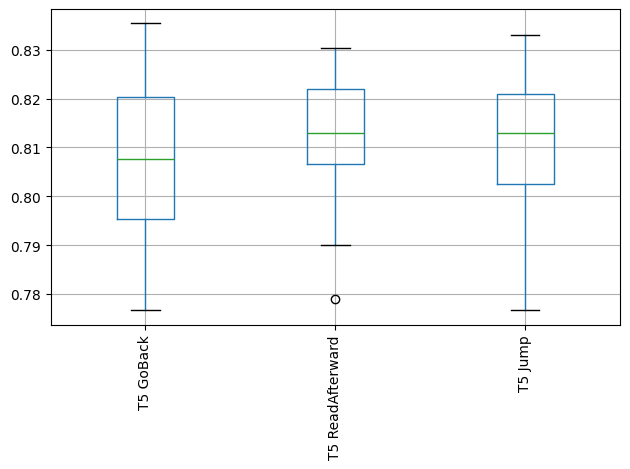

In [12]:
import matplotlib.pyplot as plt

scoresT5 = {
    'T5 GoBack': np.load("F1_t51.npy"),
    'T5 ReadAfterward': np.load("F1_t52.npy"),
    'T5 Jump': np.load("F1_t53.npy")
}

df_scoresT5 = pd.DataFrame(scoresT5)

df_scoresT5.boxplot()
plt.xticks(ticks=range(1, len(df_scoresT5.columns) + 1), labels=df_scoresT5.columns, rotation=90)
plt.tight_layout()
plt.savefig("T5 Test.png")
plt.show()

In [11]:
from scipy.stats import kruskal

kruskal_result = kruskal(scoresT5['T5 GoBack'], \
                         scoresT5['T5 ReadAfterward'], \
                         scoresT5['T5 Jump'])

print("Kruskal-Wallis statistic:", kruskal_result.statistic)
print("p value:", kruskal_result.pvalue)

if kruskal_result.pvalue < 0.05:
    print("There is a statistically relevant difference between at least 2 groups (T5).")
else:
    print("No statistically relevant difference between groups (T5).")

Kruskal-Wallis statistic: 1.7675967549825746
p value: 0.41321039799701353
No statistically relevant difference between groups (T5).
